# Spectra MCMC

Started 6 December 2019. This uses MCMC to fit model parameters simply based on a snippet of spectrum.

### Imports

In [1]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from scipy import integrate
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from fu_ori_functions_oct11_copy import *
from fu_ori_classes_oct11_copy import *
import matplotlib.gridspec as gridspec
from PyAstronomy import pyasl
import scipy.signal as signal

import emcee
import corner
import time
%matplotlib inline 

C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\pyfits\__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16

In [3]:
ATM_TABLE = dict()
ATMOS_FACTOR = 100

In [4]:
def getDataArrayMOD(data_file):
    txt = open(data_file)
    fulltxt = txt.readlines()
    # Cleaning lines
    newtxt = []
    for i in range(0,len(fulltxt), 2):
        line = fulltxt[i][:-1]
        line = line.split()
        if line[0] == '#':
            line = [line[1], line[2]]
        newtxt.append(line)
    # Casting as floats
    newtxt = np.array(newtxt).astype(np.float64)
    return newtxt

In [5]:
def direcToArray(directory):
    for temp in range(2000, 10000+ATMOS_FACTOR, ATMOS_FACTOR):
        for grav in [1.5, 4.0]:
            try:
                atmos_file = directory + 'pr.lte' + str(int(temp/ATMOS_FACTOR)) \
                        + '-' + str(grav) + '-0.0.spec'
                txt = open(atmos_file)
                fulltxt = txt.readlines()
                # Cleaning lines
                newtxt = []
                for i in range(len(fulltxt)):
                    line = fulltxt[i][:-1]
                    line = line.split()
                    newtxt.append(line)
        
                # Casting as floats
                newtxt = np.array(newtxt).astype(np.float64)
                
                # Choosing which model to use
                wav, lum = newtxt[:,0], newtxt[:,1]
                ATM_TABLE[(temp, grav)] = np.array([wav, lum])
            except:
                print('No atmosphere found for temp = ' + str(temp) + \
                      ' grav = ' + str(grav))

In [6]:
direcToArray('C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/')

No atmosphere found for temp = 7100 grav = 1.5
No atmosphere found for temp = 7100 grav = 4.0
No atmosphere found for temp = 7300 grav = 1.5
No atmosphere found for temp = 7300 grav = 4.0
No atmosphere found for temp = 7500 grav = 1.5
No atmosphere found for temp = 7500 grav = 4.0
No atmosphere found for temp = 7700 grav = 1.5
No atmosphere found for temp = 7700 grav = 4.0
No atmosphere found for temp = 7900 grav = 1.5
No atmosphere found for temp = 7900 grav = 4.0
No atmosphere found for temp = 8100 grav = 1.5
No atmosphere found for temp = 8100 grav = 4.0
No atmosphere found for temp = 8300 grav = 1.5
No atmosphere found for temp = 8300 grav = 4.0
No atmosphere found for temp = 8500 grav = 1.5
No atmosphere found for temp = 8500 grav = 4.0
No atmosphere found for temp = 8700 grav = 1.5
No atmosphere found for temp = 8700 grav = 4.0
No atmosphere found for temp = 8900 grav = 1.5
No atmosphere found for temp = 8900 grav = 4.0
No atmosphere found for temp = 9100 grav = 1.5
No atmosphere

### Interpolating grid of stellar atmospheres on same grid as data:

First, reading in data...

In [7]:
txt_in = getDataArrayMOD('gaia_out_spec_40_45.csv')
WAV_DAT = txt_in[:,0]
FLUX_DAT = txt_in[:,1]
FLUX_DAT_ERR = 0.2*FLUX_DAT

In [55]:
WAV_DAT_CLIP = WAV_DAT[1:-1]
FLUX_DAT_CLIP = FLUX_DAT[1:-1]
FLUX_DAT_ERR_CLIP = FLUX_DAT_ERR[1:-1]

In [56]:
import spectres

In [57]:
def getInterpTable(st_atm_table, waves_data):
    out_table = dict()
    for key in ATM_TABLE:
        wav, lum = ATM_TABLE[key]
#         interp_func = interpolate.interp1d(wav, lum, kind = 'linear')
#         out_table[key] = waves_data, interp_func(waves_data)
        out_table[key] =  waves_data, spectres.spectres(waves_data, wav, lum)
    return out_table

In [58]:
ATM_TABLE_INTERP = getInterpTable(ATM_TABLE, WAV_DAT)

In [59]:
ATM_TABLE_INTERP.keys()

dict_keys([(2000, 1.5), (2000, 4.0), (2100, 1.5), (2100, 4.0), (2200, 1.5), (2200, 4.0), (2300, 1.5), (2300, 4.0), (2400, 1.5), (2400, 4.0), (2500, 1.5), (2500, 4.0), (2600, 1.5), (2600, 4.0), (2700, 1.5), (2700, 4.0), (2800, 1.5), (2800, 4.0), (2900, 1.5), (2900, 4.0), (3000, 1.5), (3000, 4.0), (3100, 1.5), (3100, 4.0), (3200, 1.5), (3200, 4.0), (3300, 1.5), (3300, 4.0), (3400, 1.5), (3400, 4.0), (3500, 1.5), (3500, 4.0), (3600, 1.5), (3600, 4.0), (3700, 1.5), (3700, 4.0), (3800, 1.5), (3800, 4.0), (3900, 1.5), (3900, 4.0), (4000, 1.5), (4000, 4.0), (4100, 1.5), (4100, 4.0), (4200, 1.5), (4200, 4.0), (4300, 1.5), (4300, 4.0), (4400, 1.5), (4400, 4.0), (4500, 1.5), (4500, 4.0), (4600, 1.5), (4600, 4.0), (4700, 1.5), (4700, 4.0), (4800, 1.5), (4800, 4.0), (4900, 1.5), (4900, 4.0), (5000, 1.5), (5000, 4.0), (5100, 1.5), (5100, 4.0), (5200, 1.5), (5200, 4.0), (5300, 1.5), (5300, 4.0), (5400, 1.5), (5400, 4.0), (5500, 1.5), (5500, 4.0), (5600, 1.5), (5600, 4.0), (5700, 1.5), (5700, 4.0), (

In [131]:
class FUOriEnvironment:
    
    # Initializer / Instance Attributes
    def __init__(self, wave_lower_spec, wave_upper_spec, wave_lower_SED, wave_upper_SED):
        
        self.wave_lower_spec = wave_lower_spec
        self.wave_upper_spec = wave_upper_spec
        self.wave_lower_SED = wave_lower_SED
        self.wave_upper_SED = wave_upper_SED
        
        # Storing classes
        self.fuori = []
                
    # instance methods
    
    # Creating FU Ori object as accretion disk
    def createFUOri(self, r_star, r_outer, m_star, m_dot, inc, a_v, dist, grav, direc, atm_table):
        fuori = FUOri(r_star, r_star, r_outer, m_star, m_dot, np.radians(inc), a_v, atm_table)
        fuori.setAnnuliValues(10000, 2000, 200, 1*r_star)
        fuori.createAnnuliFromDirec(grav, direc, model='stellar atmospheres')
        fuori.prepareAnnuli(self.wave_lower_spec,self.wave_upper_spec, \
                            broaden=True, interp_type='linear')
        fuori.createModelSpectrum('stellar atmospheres', broaden=True)
        self.fuori.append(fuori)
        
    # For viewing model spectrum
    def viewModelSpectrum(self, wave_lower, wave_upper, obj_type, obj_num, broaden, redden):
        if obj_type == 'fu ori':
            return self.fuori[obj_num].viewModelSpectrum(wave_lower, wave_upper, broaden, redden)
        elif obj_type == 'rotating star':
            return self.rot_star.getLuminosity(wave_lower, wave_upper, broaden, redden)

### Making an instance of the class

In [218]:
NEW_PARAMS = [0.81, 0.66, -5.95, 71]

In [219]:
PARAMS = [0.68, 0.54, -6.76, 60]

In [220]:
M_STAR = PARAMS[0]*M_SUN
R_STAR= PARAMS[1]*R_SUN
R_OUTER = 50 * R_SUN
M_DOT = (10**PARAMS[2]) *  M_SUN / 3.154e7

A_V = 3.
INC = PARAMS[3]
DIST = 1270*3.08567758128e18
DIREC = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/'

In [221]:
%time gaia17bpi_env = FUOriEnvironment(3.69e3, 4.21e3, 0, 0)

%time gaia17bpi_env.createFUOri(r_star = PARAMS[1]*R_SUN, r_outer = R_OUTER, m_star = PARAMS[0]*M_SUN,\
                          m_dot = (10**PARAMS[2])  *M_SUN / 3.154e7, \
                                inc = PARAMS[3], a_v = 3,dist = DIST, grav = 1.5, \
                                direc = DIREC, atm_table=ATM_TABLE_INTERP)

%time gaia17bpi_env.createFUOri(r_star = NEW_PARAMS[1]*R_SUN, r_outer = R_OUTER, m_star = NEW_PARAMS[0]*M_SUN,\
                          m_dot = (10**NEW_PARAMS[2])  *M_SUN / 3.154e7, \
                                inc = NEW_PARAMS[3], a_v = 3,dist = DIST, grav = 1.5, \
                                direc = DIREC, atm_table=ATM_TABLE_INTERP)

Wall time: 6.98 ms
Wall time: 356 ms
Wall time: 250 ms


In [222]:
START = 4000
END = 4500

In [223]:
wav, lum = gaia17bpi_env.viewModelSpectrum(START, END, 'fu ori', 0, True, False)
flux  = pyasl.unred(wav, lum*np.cos(gaia17bpi_env.fuori[0].inc)/(2*np.pi*DIST**2), -gaia17bpi_env.fuori[0].a_v/3.1)

In [224]:
wav2, lum2 = gaia17bpi_env.viewModelSpectrum(START, END, 'fu ori', 1, True, False)
flux2  = pyasl.unred(wav2, lum2*np.cos(gaia17bpi_env.fuori[1].inc)/(2*np.pi*DIST**2), -gaia17bpi_env.fuori[1].a_v/3.1)

### Simple $\chi^2$ Minimization

In [225]:
from scipy.signal import correlate

In [226]:
correlate(flux*1e16, FLUX_DAT_CLIP*1e16, mode='valid')[0]

31561234124.42436

In [227]:
def getLstSqrs(theta):
    m_star, r_star, m_dot, inc = theta
    
    r_star = r_star*R_SUN
    m_dot = 10**m_dot
    m_star = m_star*M_SUN
    inc = inc
    a_v = 3
    m_dot = m_dot*  M_SUN / 3.154e7
    try:
        gaia17bpi_env = FUOriEnvironment(3.0e3, 28.5e3,0,0)
        gaia17bpi_env.createFUOri(r_star = r_star, r_outer = R_OUTER, m_star = m_star,\
                              m_dot = m_dot, inc = inc, a_v = a_v, dist = DIST, grav = 1.5, \
                                  direc = DIREC, atm_table=ATM_TABLE_INTERP)
    except:
        return 1e5

    
    
    # Converting units to properly compare model to data
    wav, lum = gaia17bpi_env.viewModelSpectrum(START, END, 'fu ori', 0, True, False)
    model = pyasl.unred(wav, 1e-8*lum*np.cos(np.radians(inc))/(2*np.pi*DIST**2), -a_v/3.1)[10:-10]

    data = FLUX_DAT_CLIP[10:-10]
    
    b, a = signal.butter(1, 0.005, 'low', analog=False)
    filtered_data = signal.filtfilt(b, a,  data)
    b, a = signal.butter(1, 0.005, 'low', analog=False)
    filtered_model = signal.filtfilt(b, a, model)
    model = model/filtered_model
    data = data/filtered_data

    return np.sum((model - data)**2)

In [187]:
from scipy import optimize
x0 = PARAMS[1:]
optimize.minimize(getLstSqrs, x0, method='Nelder-Mead', tol=1e-6)

 final_simplex: (array([[ 0.54459261, -7.39055516, 59.80619604],
       [ 0.54459258, -7.39055551, 59.80616755],
       [ 0.54459323, -7.39054699, 59.80684753],
       [ 0.54459318, -7.39054761, 59.80679814]]), array([-4.53892477e+26, -4.53892476e+26, -4.53892475e+26, -4.53892473e+26]))
           fun: -4.538924767967186e+26
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 601
           nit: 329
        status: 1
       success: False
             x: array([ 0.54459261, -7.39055516, 59.80619604])

### Plotting data with model

In [228]:
def chiSquareSum(data, model):
    return np.sum((data - model)**2/model**2)

In [229]:
b, a = signal.butter(1, 3e-3, 'low', analog=False)
filtered_data = signal.filtfilt(b, a,   FLUX_DAT_CLIP[10:-10])
b, a = signal.butter(1, 3e-3, 'low', analog=False)
filtered_model = signal.filtfilt(b, a,   1e-8*flux[10:-10])
b, a = signal.butter(1, 3e-3, 'low', analog=False)
filtered_model_sed = signal.filtfilt(b, a,   1e-8*flux2[10:-10])

data_new =  FLUX_DAT_CLIP[10:-10]/filtered_data
model_new = 1e-8*flux[10:-10]/filtered_model
model_new_sed = 1e-8*flux2[10:-10]/filtered_model_sed

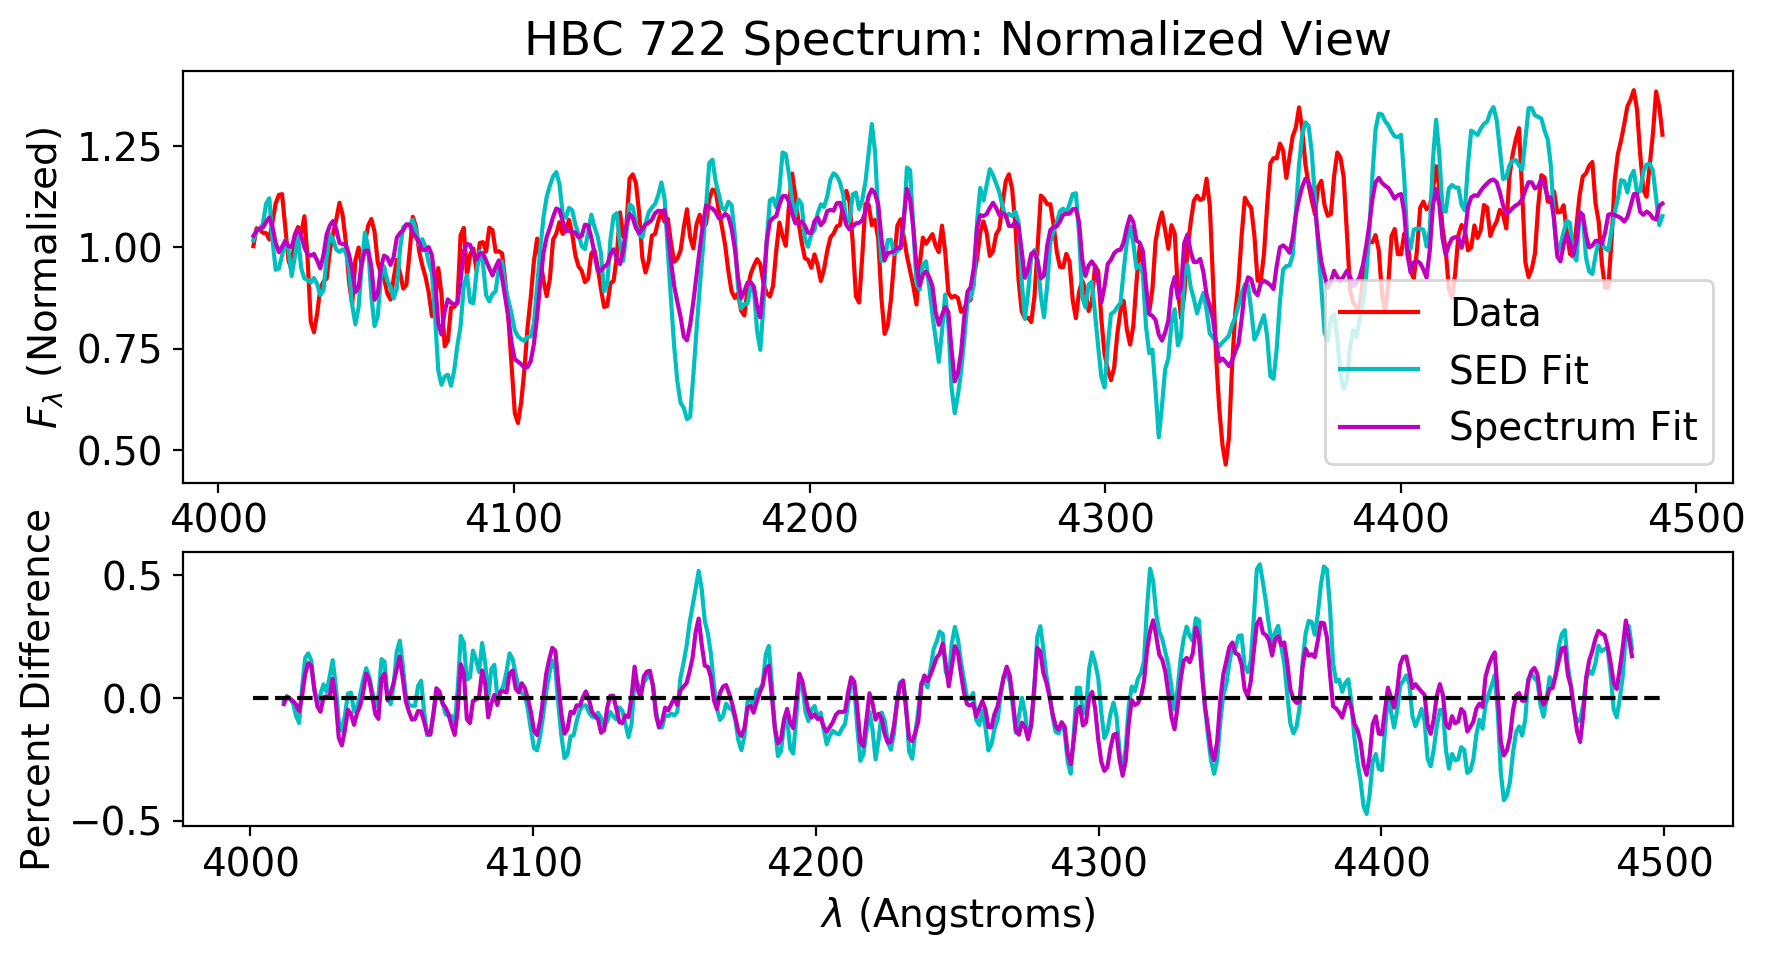

In [230]:
fig=plt.figure(figsize=(10, 5), dpi= 200)
gs = gridspec.GridSpec(2, 1,height_ratios=[3, 2])
plt.rcParams.update({'font.size': 14})

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# ax.plot(WAV_DAT_CLIP[10:-10], FLUX_DAT_CLIP[10:-10], 'r-', markersize=1, alpha=1, label='Data')
# ax.plot(wav[10:-10],1e-8*flux[10:-10], 'b-', markersize = 1,  label='Spectrum fit')

ax.plot(WAV_DAT_CLIP[10:-10], data_new,  'r-', markersize=1, alpha=1, label='Data')
ax.plot(wav[10:-10], model_new, 'c-', markersize = 1,  label=r'SED Fit')
ax.plot(wav[10:-10], model_new_sed, 'm-', markersize = 1,  label=r'Spectrum Fit')

# ax2.plot(wav[10:-10], 100*(FLUX_DAT_CLIP[10:-10]-1e-8*flux[10:-10]  )/(1e-8*flux[10:-10]), '-', markersize=1)
ax2.plot(wav[10:-10], (data_new - model_new), 'c-', alpha = 1, markersize=1)
ax2.plot(wav[10:-10], (data_new - model_new_sed), 'm-', alpha=1, markersize=1)

# ax.axvspan(3842, 3847, color='green', alpha=0.15)
# ax2.axvspan(3842, 3847, color='green', alpha=0.15)

ax2.plot(wav, np.zeros(len(flux)), 'k--')


ax2.set_xlabel(r'$\lambda$ (Angstroms)')
ax.set_ylabel(r'$F_\lambda$ (Normalized)')
ax2.set_ylabel(r'Percent Difference')

ax.set_title('HBC 722 Spectrum: Normalized View')
# ax.set_xlim(5002, 5449)
# ax2.set_ylim(-0.7, 0.7)


ax.legend(loc='lower right')
# plt.savefig("sed_gaia17bpi_75.png", dpi=200, bbox_inches='tight')
plt.show()

In [195]:
M_STAR_LOW = 0.5
M_STAR_HIGH = 0.9

R_STAR_LOW = 0.3
R_STAR_HIGH = 1.2

M_DOT_LOW = -7.
M_DOT_HIGH = -5.

INC_LOW = 10
INC_HIGH = 80

In [196]:
bnds = ((M_STAR_LOW, M_STAR_HIGH),(R_STAR_LOW, R_STAR_HIGH),(M_DOT_LOW, M_DOT_HIGH), (INC_LOW, INC_HIGH) )

In [197]:
from scipy import optimize
x0 =PARAMS
%time optimize.minimize(getLstSqrs, x0, method='TNC', bounds=bnds, tol=1e-6)

Wall time: 1min 20s


     fun: -4.608971641095359e+26
     jac: array([1.04581811e+29, 1.49159446e+29, 1.20070989e+30, 1.11594859e+27])
 message: 'Linear search failed'
    nfev: 92
     nit: 4
  status: 4
 success: False
       x: array([ 0.70700547,  0.68870341, -6.99993817, 78.91017988])

## MCMC Routine

In [198]:
def lnlike(theta, x, y, yerr):
    m_star, r_star, m_dot, inc = theta
    
    r_star = r_star*R_SUN
    m_dot = 10**m_dot
    m_star = m_star*M_SUN
    inc = inc
    
    m_dot = m_dot*  M_SUN / 3.154e7
    try:
    
        gaia17bpi_env = FUOriEnvironment(3.0e3, 28.5e3,0,0)
        gaia17bpi_env.createFUOri(r_star = r_star, r_outer = R_OUTER, m_star = m_star,\
                              m_dot = m_dot, inc = inc, a_v = A_V, dist = DIST, grav = 1.5, \
                                  direc = DIREC, atm_table=ATM_TABLE_INTERP)
    
    # Accounts for any random case where the model may not be generated properly given a certain combination
    # of parameters. This has only happened once, but it's presumably when the maximum temperature is too low.
    except:
        return 0
    
    # Converting units to properly compare model to data
    wav, lum = gaia17bpi_env.viewModelSpectrum(START, END, 'fu ori', 0, True, False)
    model = pyasl.unred(wav, 1e-8*lum*np.cos(np.radians(inc))/(2*np.pi*DIST**2), -A_V/3.1)[10:-10]
    
    # Dividing by low-pass filter to normalize
    b, a = signal.butter(1, 0.005, 'low', analog=False)
    model = model/signal.filtfilt(b, a, model)

    inv_sig = 1/yerr
    return np.sum(np.log((1/np.sqrt(2*np.pi))*inv_sig) - 0.5*((y - model)*inv_sig)**2)

In [199]:
M_STAR_LOW = 0.2
M_STAR_HIGH = 1.0

R_STAR_LOW = 0.4
R_STAR_HIGH = 4.0

M_DOT_LOW = -7.5
M_DOT_HIGH = -4

INC_LOW = 5
INC_HIGH = 85

In [200]:
def lnprior(theta):
    m_star, r_star, m_dot, inc= theta
    if M_DOT_LOW  < m_dot < M_DOT_HIGH \
    and M_STAR_LOW < m_star < M_STAR_HIGH\
    and R_STAR_LOW < r_star < R_STAR_HIGH\
    and INC_LOW < inc < INC_HIGH:
        return 0.0
    return -np.inf

In [201]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp + lnlike(theta, x, y, yerr))

In [211]:
ndim, nwalkers = 4, 12
m_star_start = 0.58
r_star_start = 0.5
m_dot_start = -6.5
inc_start = 50
start = np.array((m_star_start, r_star_start, m_dot_start, inc_start))
pos = [start + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [212]:
b, a = signal.butter(1, 0.005, 'low', analog=False)
filtered_data = signal.filtfilt(b, a,   FLUX_DAT_CLIP)

In [213]:
x = WAV_DAT_CLIP
y_meas = FLUX_DAT_CLIP/filtered_data
y_err = y_meas/10

In [214]:
lnprob((m_star_start, r_star_start, m_dot_start, inc_start), x[10:-10],y_meas[10:-10],y_err[10:-10])

109.65108978911007

In [215]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x[10:-10], y_meas[10:-10], y_err[10:-10]))
%time sampler.run_mcmc(pos, 2000, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [47:46<00:00,  1.14s/it]


Wall time: 47min 48s


State([[ 0.82715371  0.9384343  -5.49962548 84.49995472]
 [ 0.87493087  0.55628184 -6.20092464 48.14688935]
 [ 0.94813271  1.04545889 -5.41849959 75.77283559]
 [ 0.93988074  0.64625433 -6.05352389 50.67436957]
 [ 0.86342766  0.63023557 -6.02831864 79.76354667]
 [ 0.92398445  0.79647605 -5.76176813 80.44201701]
 [ 0.65360751  0.5367689  -6.11777039 52.98741027]
 [ 0.7189013   0.66928995 -5.87329346 69.26462401]
 [ 0.80891027  0.67146532 -5.92032224 61.75353726]
 [ 0.97899821  0.76735936 -5.83483989 58.11702108]
 [ 0.77887527  0.69500011 -5.86201823 67.01115067]
 [ 0.81830934  0.62212692 -6.02810785 58.10512072]], log_prob=[236.12447726 236.60523055 235.60705969 234.01618402 234.44627428
 236.32335056 235.41949059 236.95084813 237.51335005 236.6114941
 236.74056049 236.63797494], blobs=None, random_state=('MT19937', array([ 519203251,   66297261, 3887371404, 2118938661, 1482575761,
        670084948, 1029099359, 1481259393, 2138367564,  325986021,
        459848466, 1830416940, 348111922

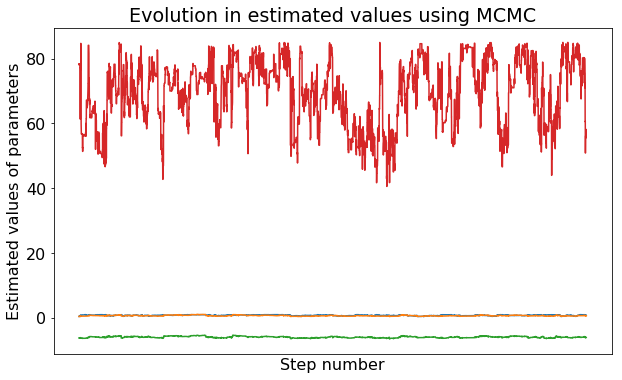

In [216]:
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))
fig = plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 16})

plt.plot(samples)
plt.xlabel('Step number')
plt.ylabel('Estimated values of parameters')
plt.title('Evolution in estimated values using MCMC')
plt.xticks([])
plt.show()

Quantiles:
[(0.16, 0.6591909462569527), (0.5, 0.8124910739704541), (0.84, 0.9424999587364346)]
Quantiles:
[(0.16, 0.532935942758312), (0.5, 0.6585591904081269), (0.84, 0.8063849407756298)]
Quantiles:
[(0.16, -6.178100188729437), (0.5, -5.949437943899814), (0.84, -5.705225086996884)]
Quantiles:
[(0.16, 57.93742875340625), (0.5, 71.29280383291184), (0.84, 80.21280107925067)]


C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


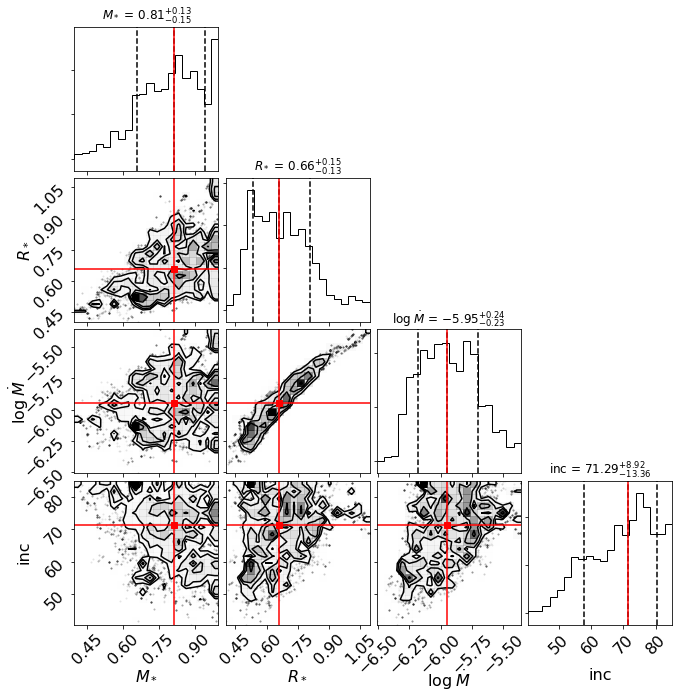

In [217]:
median_calcuated = np.median(samples, axis=0)

fig = corner.corner(samples, labels=[r'$M_*$', r'$ R_*$',r'$\log\;\dot{M}$', 'inc'], verbose=True,
                       quantiles=(0.16, 0.5,0.84), plot_contours=True, scale_hist=True,
                       show_titles=True, title_kwargs={"fontsize": 12})

axes = np.array(fig.axes).reshape((ndim, ndim))

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(median_calcuated[i], color="r")
    
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(median_calcuated[xi], color="r")
        ax.axhline(median_calcuated[yi], color="r")
        ax.plot(median_calcuated[xi], median_calcuated[yi], "sr")

fig.show()
# fig.savefig("gaia17bpi_1028_55_100pts.png", dpi=140)

## Plotting after fit

In [55]:
M_STAR = (10**-0.30)*M_SUN
R_STAR= 0.65*R_SUN
R_OUTER = 15 * R_STAR
M_DOT = (10**-0.62) * 1e-6 * M_SUN / 3.154e7

A_V = 3.

INC = 55.

DIST = 1.27e3*3.08567758128e18
DIREC = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/'

In [56]:
gaia17bpi_env = FUOriEnvironment(1.5e3, 30.5e3)
gaia17bpi_env.createFUOri(r_star = R_STAR, r_outer = R_OUTER, m_star = M_STAR,\
                          m_dot = M_DOT, inc = INC, a_v = A_V,dist = DIST, grav = 1.5, direc = DIREC, atm_table=ATM_TABLE)
%time modSpec = gaia17bpi_env.viewModelSpectrum(2.9e3, 28e3, True)
wav, lum = modSpec

Wall time: 22.9 ms


In [57]:
gaia17bpi_env.fuori.annuli[0].temp

6000.0

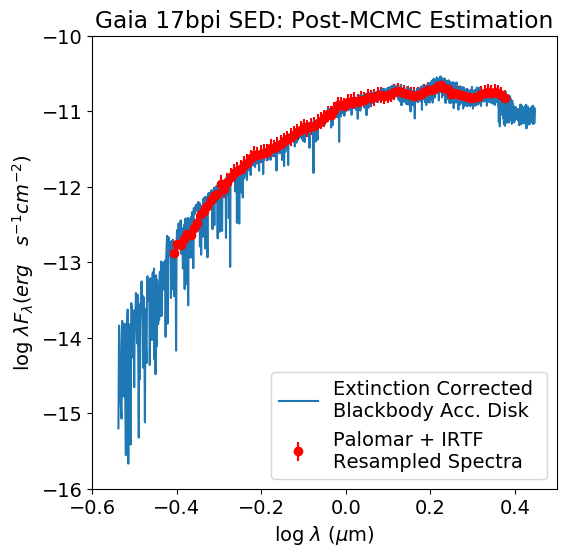

In [59]:
fig=plt.figure(figsize=(6, 6), dpi= 100)
plt.rcParams.update({'font.size': 14})
plt.plot(np.log10(wav*1e-4), np.log10(lum*wav*1e-8*np.cos(np.radians(INC))/(2*np.pi*DIST**2)), \
         '-', label='Extinction Corrected \nBlackbody Acc. Disk')

plt.errorbar(WAV_DAT, FLUX_DAT, yerr=FLUX_DAT_ERR, marker='o', \
             linestyle='', color='r',label='Palomar + IRTF \nResampled Spectra')

plt.xlabel(r'log $\lambda$ ($\mu$m)')
plt.ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')
plt.title('Gaia 17bpi SED: Post-MCMC Estimation')
plt.ylim(-16, -10)
plt.xlim(-0.6, 0.5)
plt.legend()
# plt.savefig("sed_gaia17bpi_75.png", dpi=200, bbox_inches='tight')
plt.show()